In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from numba import jit, cuda

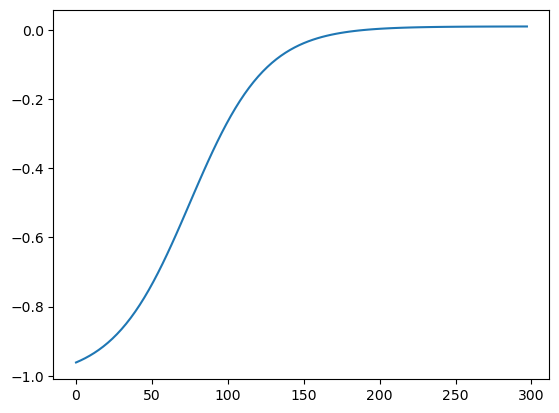

In [52]:
N = 150
O = 0.51
S = 3
D = 0.5
t = np.arange(0, 300, 3)

def temp(t, N, O, S, D):
    return O*np.tanh(S*(t/N - 0.5)) - D

nu = temp(t,N, O, S, D)
plt.plot(t, nu)
    

In [3]:
J = np.random.rand(N,N) - 0.5*np.ones([N,N])
h = np.random.rand(N) - 0.5*np.ones(N)

330.72391023950286


Text(0, 0.5, 'Spin value, s')

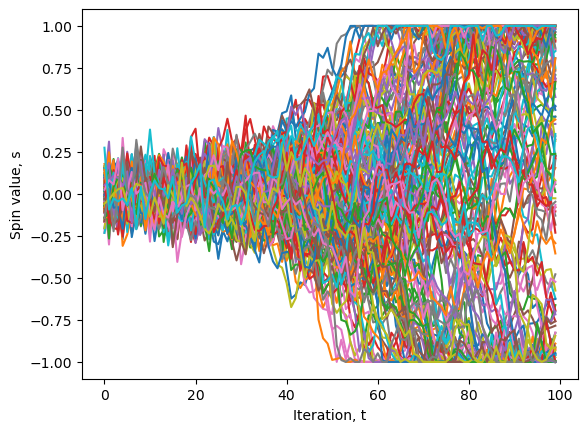

In [55]:
ksi = 0.02
alpha = 0.
sat = 1
J = -1*J
h = -1*h

def simcim_demo(J, h, nu, ksi, alpha, sat):
    N = len(h)
    x = np.zeros(N)
    mem = []
    delta = np.zeros(N)
    for i in range(int(len(nu)/1)):
        f = np.random.normal(0, 0.1, N)
        delta = nu[i]*x + ksi*(np.dot(J, x) + h)+f+alpha*delta
        x = x + delta
        x = np.where(np.abs(x) < sat, x, sat*np.sign(x))
        mem.append(x)
    #print(x)
    return np.sign(x), np.array(mem)

solution, memory = simcim_demo(J, h, nu, ksi, alpha, sat)
memory = memory.T
print(np.dot(solution, np.dot(J, solution)) + np.dot(h, solution))

plt.figure()
for i in range(N):
    plt.plot(memory[i], label = str(i))
#plt.legend(loc = 'upper left')
plt.xlabel('Iteration, t')
plt.ylabel('Spin value, s')
        

In [56]:
sol = []
en = []

def simcim(J, h, nu, ksi, alpha, sat):
    N = len(h)
    x = np.zeros(N)
    delta = np.zeros(N)
    for i in range(int(len(nu)/1)):
        f = np.random.normal(0, 0.15, N)
        delta = nu[i]*x + ksi*(np.dot(J, x) + h)+f+alpha*delta
        x = x + delta
        x = np.where(np.abs(x) < sat, x, sat*np.sign(x))
    return np.sign(x)

for ite in range(1000):
    solution = simcim(J, h, nu, ksi, alpha, sat)
    sol.append(solution)
    en.append(np.dot(solution, np.dot(J, solution)) + np.dot(h, solution))

sol = np.array(sol)
en = np.array(en)

print(np.max(en))
mm = np.max(en)
print(sol[np.argmax(en)])
print(len(np.where(en == mm)[0])/len(en))

391.9276379793313
[-1. -1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1.
 -1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.  1.  1. -1. -1.
 -1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.
 -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1.  1.
 -1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1.  1. -1.  1.
  1.  1. -1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1.
 -1.  1. -1.  1.  1.  1.]
0.001


In [218]:
sol = np.array(sol)
en = np.array(en)

print(np.max(en))
mm = np.max(en)
print(sol[np.argmax(en)])
print(len(np.where(en == mm)[0])/len(en))

103.9957020665401
[ 1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.
  1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1. -1. -1. -1.]
0.0002720348204570185


In [221]:
# normal function to run on cpu

@jit(target_backend='cuda')     
def func(en, sol):                                
    for i in range(10000):
        solution, m = simcim_demo(J, h, nu, ksi, alpha, sat)
        sol[i][0:N] = solution[0:N]
        en[i] = np.dot(solution, np.dot(J, solution)) + np.dot(h, solution)
    return np.max(en), sol[np.argmax(en)]
  
    
en = np.zeros(10000)
ssol = np.zeros([10000, N])
e, ssol = func(en,sol)       

KeyError: "<class 'numba.core.cpu.CPUTargetOptions'> does not support option: 'target_backend'"

In [112]:
s = list(it.product((1,-1), repeat = 10)) 
s = np.array(s)
Q = [0]*1024
mid = 0
midd = 0
for k in range(1024):   
    for i in range(10):
        for j in range(10):
            mid = J[i][j]*s[k][i]*s[k][j]+mid
        midd = s[k][i]*h[i]+midd
    Q[k] = mid - midd
    mid = 0
    midd = 0
Q = np.array(Q)
print(np.max(Q))
print(s[Q.argmax()])

9.889878970889516
[-1  1 -1 -1 -1 -1  1  1  1 -1]
